# EMNIST Dataset Training & Testing - for Handwritten Text OCR

The EMNIST dataset is a set of handwritten characters derived from the NIST (National Institute of Standards and Technology - U.S. Government Agency.  Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

There are six different splits provided in this dataset. A short summary of the dataset is provided below:

1. EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
2. EMNIST ByMerge: 814,255 characters. 47 unbalanced classes.
3. EMNIST Balanced:  131,600 characters. 47 balanced classes.
4. EMNIST Letters: 145,600 characters. 26 balanced classes.
5. EMNIST Digits: 280,000 characters. 10 balanced classes.
6. EMNIST MNIST: 70,000 characters. 10 balanced classes.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#mnist & emnist are python libraries which have the EMNIST and MNIST datasets. 
from mnist.loader import MNIST

import numpy as np
import matplotlib.pyplot as plt

from emnist import extract_training_samples
from emnist import list_datasets
from emnist import extract_test_samples

## Loading the Dataset and Image Pre-Processing

In [7]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [2]:
train_images, train_labels = extract_training_samples('byclass')
print(train_images.shape)
print(train_labels.shape)

(697932, 28, 28)
(697932,)


In [3]:
test_images, test_labels = extract_test_samples('byclass')
print(test_images.shape)
print(test_labels.shape)

(116323, 28, 28)
(116323,)


In [4]:
train_images = tf.keras.utils.normalize(train_images, axis = 1)
test_images = tf.keras.utils.normalize(test_images, axis = 1)

train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

### We load 'by_class' split from EMNIST as it has the most characters; & then we normalize the data (change the pixel range from the character pictures from 0 -> 255, to 0 -> 1 for better model performance

In [5]:
# Specify the arguments
rotation_range_val = 15
width_shift_val = 0.10
height_shift_val = 0.10

In [6]:
# Create the class object
train_datagen = ImageDataGenerator(rotation_range = rotation_range_val,
                             width_shift_range = width_shift_val,
                             height_shift_range = height_shift_val)

In [7]:
# Fit the generator
train_datagen.fit(train_images.reshape(train_images.shape[0], 28, 28, 1))

### We need to augmentate (or change) the data to create more variance for the neural network; which allows for better generalization across data & increased performance. Meaning that our model has better chances of accurately predicting a character that is slightly crooked or rotated.

In [8]:
# Define number of rows & columns
num_row = 4
num_col = 8
num= num_row*num_col

BEFORE:



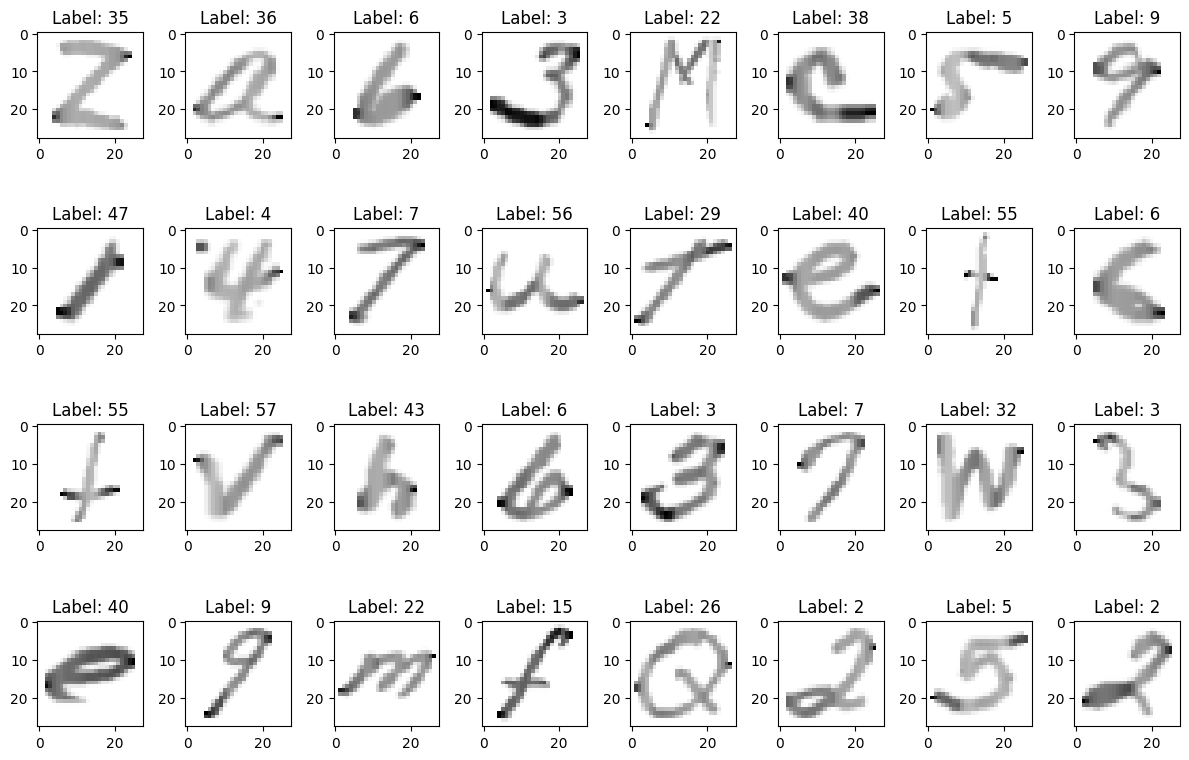

In [9]:
# Plot 'before'
print('BEFORE:\n')

# Plot images
fig1, axes1 = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
     ax = axes1[i//num_col, i%num_col]
     ax.imshow(train_images[i], cmap='gray_r')
     ax.set_title('Label: {}'.format(train_labels[i]))
plt.tight_layout()
plt.show()

AFTER:



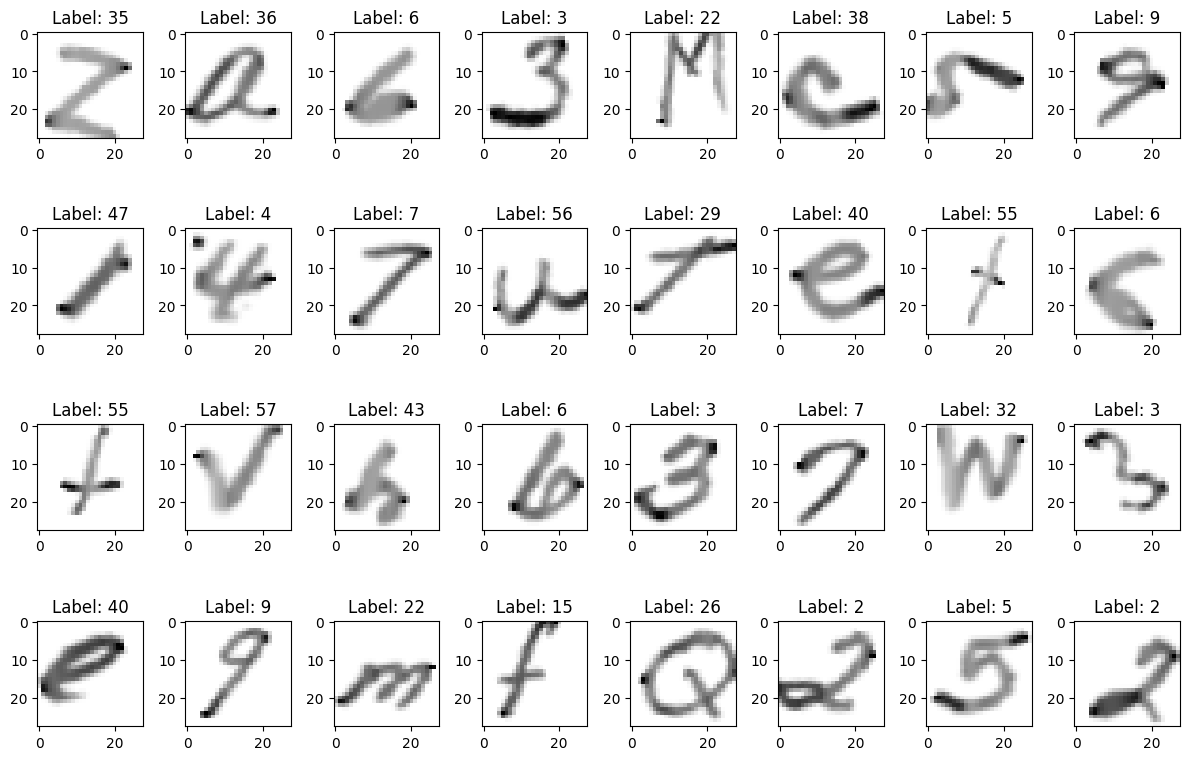

In [10]:
# Plot 'after'
print('AFTER:\n')
fig2, axes2 = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for X, Y in train_datagen.flow(train_images.reshape(train_images.shape[0], 28, 28, 1),train_labels.reshape(train_labels.shape[0], 1),batch_size=num,shuffle=False):
     for i in range(0, num):
          ax = axes2[i//num_col, i%num_col]
          ax.imshow(X[i].reshape(28,28), cmap='gray_r')
          ax.set_title('Label: {}'.format(int(Y[i])))
     break
plt.tight_layout()
plt.show()

In [11]:
val_datagen = ImageDataGenerator()
val_datagen.fit(test_images.reshape(test_images.shape[0], 28, 28, 1))
val_datagen

## Model Architecture & Training

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(62, activation = 'softmax')
])

### This model has various interconnected layers that perform the computations. This is a Convolutional Neural Network and it has 2 Convolutional layers each followed by a Max Pooling layer. The Convolutional Layers are followed by 2 fully connected dense layers with 256 then 128 neurons. Finally, the model has an output layer with 62 nodes. Each node in the final layer represents a class of characters and the model will output 62 different values in the range 0 -> 1 (the probability that the image belongs to a class).

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

### Compile the model & then training it for 15 epochs (or 'rounds') with the goal of increasing accuracy in each round.

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
history = model.fit(train_datagen.flow(train_images, train_labels, batch_size=1024),
         validation_data= val_datagen.flow(test_images, test_labels,
         batch_size=32), epochs= 15)

Epoch 1/15


2023-03-22 15:02:58.900873: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


682/682 [==============================] - 109s 160ms/step - loss: 1.0431 - accuracy: 0.6952 - val_loss: 0.4683 - val_accuracy: 0.8368
Epoch 2/15
682/682 [==============================] - 108s 159ms/step - loss: 0.5511 - accuracy: 0.8106 - val_loss: 0.4199 - val_accuracy: 0.8485
Epoch 3/15
682/682 [==============================] - 108s 159ms/step - loss: 0.4933 - accuracy: 0.8265 - val_loss: 0.3979 - val_accuracy: 0.8543
Epoch 4/15
682/682 [==============================] - 109s 160ms/step - loss: 0.4642 - accuracy: 0.8344 - val_loss: 0.3862 - val_accuracy: 0.8572
Epoch 5/15
682/682 [==============================] - 109s 159ms/step - loss: 0.4455 - accuracy: 0.8400 - val_loss: 0.3812 - val_accuracy: 0.8590
Epoch 6/15
682/682 [==============================] - 109s 160ms/step - loss: 0.4314 - accuracy: 0.8436 - val_loss: 0.3770 - val_accuracy: 0.8594
Epoch 7/15
682/682 [==============================] - 109s 159ms/step - loss: 0.4214 - accuracy: 0.8471 - val_loss: 0.3752 - val_accura

In [16]:
scores = model.evaluate(test_images,test_labels)

3636/3636 [==============================] - 8s 2ms/step - loss: 0.3586 - accuracy: 0.8634


### 86.34% of accuracy is acceptable for OCR standards as it is imposible to accurately predict 'bad' handwriting the entire time (even for humans this is a challenging task).

In [17]:
print("Accuracy: %.2f%%"%(scores[1]*100))

Accuracy: 86.34%


## Model History Graphs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


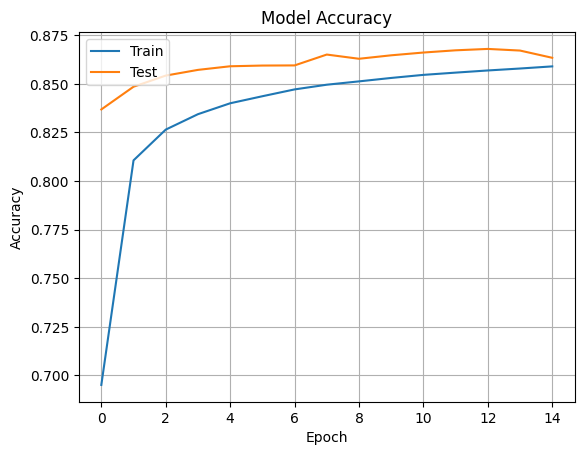

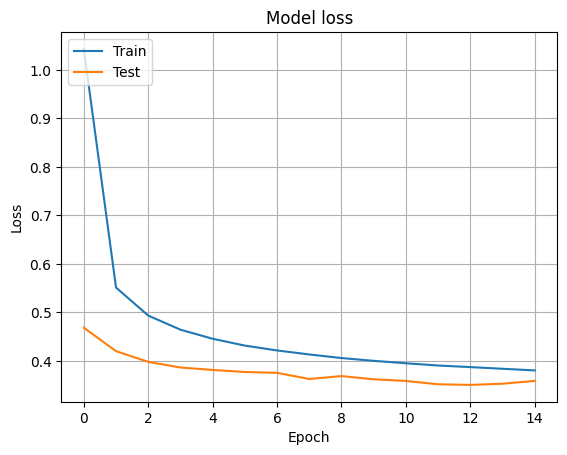

In [18]:
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

## Save Model

In [19]:
#model.save('EMNIST_based_Handwritten_text.model')

INFO:tensorflow:Assets written to: EMNIST_based_Handwritten_text.model/assets


INFO:tensorflow:Assets written to: EMNIST_based_Handwritten_text.model/assets


In [22]:
model.save_weights('EMNIST_based_Handwritten_Text_Model.h5')

In [23]:
model.save('EMNIST_based_Handwritten_Text_Model.h5')

## Confirm Model works when Loading

In [24]:
from tensorflow.keras.models import load_model

In [25]:
model = load_model('EMNIST_based_Handwritten_Text_Model.h5')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0